# BioMassters UNet Baseline

This is a (very) basic pytorch ligning baseline using a UNet for getting started with the BioMassters challenge. 

This notebook assumes you have the training, testing and target data downloaded in folders called: `train_features`, `test_features` and `train_agbm`, as well as having the features metadata file in the same folder as the notebook. 

The training data doesn't need to be fully downloaded (there's a lot of it after all), but it's assumed that the targets are complete. If you want to make a prediction the testing data also needs to be complete. 

I recently found [torchgeo](https://github.com/microsoft/torchgeo), which has a lot of neat functionality for dealing with remote sensing data, and have tried to use some of the functionality it provides. 
**Note:** so far, I haven't found many of it's features that useful. I did however use the weights of a pre-trained ResNet50 trained on Sentinel-2 data, which is used below. 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, Normalize
import torch.nn.functional as F
import pandas as pd
import segmentation_models_pytorch as smp
import os
from torchvision.io import read_image
import rasterio
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
import warnings
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import wandb

# Our rasters contain no geolocation info, so silence this warning from rasterio
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

In [2]:
# Download this if you want to use weights that were pre-trained on Sentinel-2 data
# !wget https://zenodo.org/record/5610000/files/resnet50-sentinel2.pt

In [3]:
features_metadata = "../features_metadata_FzP19JI.csv"
features_df = pd.read_csv(features_metadata)
train_img_dir = "../train_features/"
test_img_dir = "../test_features/"

label_dir = "../train_agbm/"

## Define a dataset

This defines a dataset for Sentinel-2 data. 
Here it uses only one time step, i.e. time `06`, July of each year. 

The dataset will look at which files are actually available and only use those. 
Useful if you have only downloaded a subset of the data. 


In [5]:
class SentinelDataset2(Dataset):
    def __init__(self, annotations_file, img_dir, label_dir=None, transform=None, target_transform=None):
        self.dataframe = pd.read_csv(annotations_file)
        self.chip_ids = self.dataframe.chip_id.unique()
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform
        
        available = os.listdir(img_dir)
        self.chip_ids = [x for x in self.chip_ids if x + "_S2_06.tif" in available]
        

    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.chip_ids[idx] + "_S2_06.tif")
        image = torch.tensor(rasterio.open(img_path).read().astype(np.float32)[:10])
        # Normalize image with mean 0 and stddev 1. Add a little bit to div to avoid dividing by 0
        image = (image.permute(1,2,0) - image.mean(dim=(1,2)))/(image.std(dim=(1,2)) + 0.01)
        image = image.permute(2,0,1)
        
       
        label_path = os.path.join(self.label_dir, self.chip_ids[idx] + "_agbm.tif")
        label = torch.tensor(rasterio.open(label_path).read().astype(np.float32))

        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    


Create datasets and split into train and validation. 

In [6]:
train_dataset = SentinelDataset2(features_metadata, train_img_dir, label_dir)
train_size = int(0.8*len(train_dataset))
valid_size = len(train_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers = 6)
valid_dataloader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers = 6)

test_dataset = SentinelDataset2(features_metadata, test_img_dir)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers = 6)

## Define model

First we define a relatively basic model with normal pytorch lightning boilerplate

In [7]:
class Sentinel2Model(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train/loss", loss)
        self.log("train/rmse", torch.sqrt(loss))
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("valid/loss", loss)
        self.log("valid/rmse", torch.sqrt(loss))
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def forward(self, x):
        return self.model(x)

    

First we define a relatively simple UNet using segmentation models pytorch:

In [8]:
base_model = smp.Unet(
    encoder_name="resnet50",       
    in_channels=10,                 
    classes=1,                     
)


Next we load the weights that were pre-trained on sentinel-2 data

In [9]:
base_model.encoder.load_state_dict(torch.load("resnet50-sentinel2.pt"))
s2_model = Sentinel2Model(base_model)


Initialize the Weights and Biases logger (optional)

In [10]:
wandb_logger = WandbLogger(name='Sentinel_2_ResNet50',project='BioMassters_baseline')


wandb: Currently logged in as: fnands. Use `wandb login --relogin` to force relogin


Define a trainer and start training:

In [11]:
# Initialize a trainer
trainer = Trainer(
    accelerator="gpu",
    max_epochs=100,
    logger=[wandb_logger],
)
# Train the model ⚡
trainer.fit(s2_model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 32.5 M
-------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.172   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/f/miniconda3/envs/BioMassters/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Prediction

Loop over all chips in testing set, and make a prediction for each case. 

In [12]:
available = os.listdir(test_img_dir)
chip_ids = set([x[0:8] for x in available])

test_image_paths = [os.path.join(test_img_dir, x + "_S2_06.tif") for x in chip_ids]

for chip_id in tqdm(chip_ids):
    image_path = os.path.join(test_img_dir, f"{chip_id}_S2_06.tif")
    
    test_im = torch.tensor(rasterio.open(image_path).read().astype(np.float32)[:10])
    test_im = (test_im.permute(1,2,0) - test_im.mean(dim=(1,2)))/(test_im.std(dim=(1,2)) + 0.01)
    test_im = test_im.permute(2,0,1)
    pred = s2_model(test_im.unsqueeze(0).to("cuda"))
    
    
    im = Image.fromarray(pred.squeeze().cpu().detach().numpy())
    im.save(f"preds/{chip_id}_agbm.tif", format="TIFF", save_all=True)


 10%|████████▋                                                                             | 281/2773 [00:05<00:53, 46.88it/s]


KeyboardInterrupt: 

## A quick visualization

In [13]:
# Load data
test_im = torch.tensor(rasterio.open("../train_features/29cc01ea_S2_06.tif").read().astype(np.float32)[:10])
test_label = torch.tensor(rasterio.open("../train_agbm/29cc01ea_agbm.tif").read().astype(np.float32)[:10])

# Normalize
test_im = (test_im.permute(1,2,0) - test_im.mean(dim=(1,2)))/(test_im.std(dim=(1,2)) + 0.01)
test_im = test_im.permute(2,0,1)



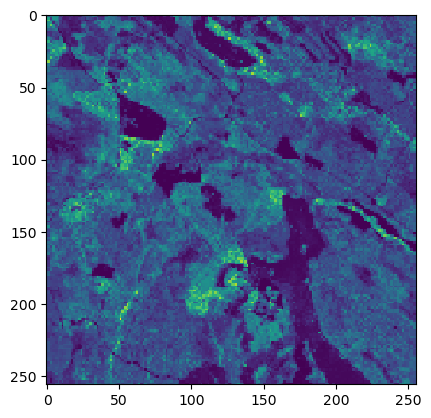

In [18]:
# Show ground truth
plt.imshow(test_label.permute(1,2,0).numpy(), interpolation='nearest')
plt.show()

In [16]:
# Predict
pred = s2_model(test_im.unsqueeze(0).to("cuda"))

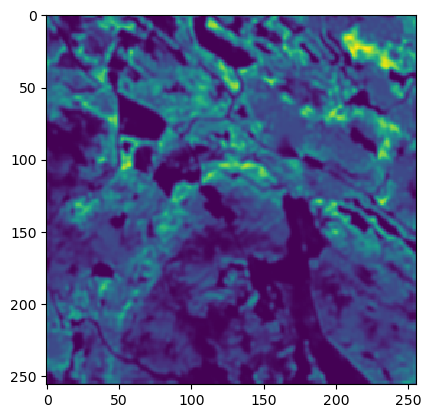

In [19]:
# Show predictions
plt.imshow(pred.cpu().squeeze().detach().numpy(), interpolation='nearest')
plt.show()